**Reconocimiento de Neumonía con imágenes de radiografias**

***Grupo 04***

***Andrés Viñé Sánchez, Beatriz Aedo Díaz, Candela Esquinas Sánchez, José Antonio Ruiz Heredia***

## 1. Importación de librerías y cargar datos

In [14]:
# TensorFlow 
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Otros
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time
import cv2
import seaborn as sns
from Data_Paths import *
from keras.applications.resnet50 import ResNet50

Parámetros de preprocesado

In [15]:
blur = 1
contraste = 2.5
grid = 8
umbral = 120
resize = 220

### 1.1. Image Data Generators

In [16]:
# Función para redimensionar una imagen
def resize_image(image):
    resized_image = cv2.resize(image, (resize, resize))
    return resized_image

# Función umbral
def threshold_image(image):
  _, threshold_image = cv2.threshold(image, umbral, 255, cv2.THRESH_BINARY)  
  return threshold_image


# Función PreProcesado
def preprocess_image(img):
    resized_img = resize_image(img)
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    smooth_img = cv2.medianBlur(gray_img, blur)
    clahe = cv2.createCLAHE(clipLimit = contraste, tileGridSize=(grid,grid))
    contrast_img = clahe.apply(smooth_img)
    threshold_img = threshold_image(contrast_img)
    
    return preprocess_input(threshold_img)

# Función DataAugmentation
# def custom_augmentation(img):
#     preprocessed_img = preprocess_image(img)

#     # Apply masking (Circular mask)
#     mask = np.zeros_like(preprocessed_img)
#     center = (preprocessed_img.shape[0] // 2, preprocessed_img.shape[1] // 2)
#     radius = min(preprocessed_img.shape[0], preprocessed_img.shape[1]) // 3
#     cv2.circle(mask, center, radius, (255, 255, 255), -1)
#     masked_image = cv2.bitwise_and(preprocessed_img, mask)

#     # Add noise
#     noisy_image = cv2.addWeighted(masked_image, 1, 0.2 * np.random.randn(*masked_image.shape), 0, 0)

#     return preprocess_input(noisy_image)


In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input

)


In [18]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATASET,
    target_size = (220, 220),
    batch_size = 16,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        TEST_DATASET,
        target_size = (220, 220),
        batch_size = 8,
        class_mode = 'binary'
)
test_generator = test_datagen.flow_from_directory(
    VAL_DATASET,
    shuffle = False,
    target_size = (220, 220),
    batch_size = 32,
    class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## 2. Entrenamos el modelo

### 2.1. ResNet50V2

In [19]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications import ResNet50V2

In [20]:
input_shape = (220, 220, 3)

# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(weights = 'imagenet',
                        input_shape = input_shape,
                        include_top = False)

for layer in base_model.layers:
    layer.trainable = False
    
# Añadimos nuevas capas
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model and new layers into a single model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

In [21]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 220, 220,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 226, 226,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 110, 110,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 112, 112,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 55, 55,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 55, 55,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 55, 55,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 55, 55,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 55, 55,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 55, 55,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 57, 57,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 55, 55,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 55, 55,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 55, 55,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 55, 55,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 55, 55,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 55, 55,    │          0 │ conv2_block1_0_c

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [22]:
CHECKPOINT_PATH = os.path.join(MODEL_DATASET, 'pneumonia_classification_model_checkpoint.weights.h5')

# Create checkpoint callback.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                      save_weights_only = True,
                                      monitor = "val_accuracy",
                                      save_best_only = True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs.
# If val loss decreases for 3 epochs, stop training.
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                            mode = "min",
                                            patience = 3, 
                                            restore_best_weights = True)

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = len(train_generator)//16,
                    epochs = 5,
                     callbacks=[checkpoint_callback, callback])

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7812 - loss: 0.5455 - val_accuracy: 0.7292 - val_loss: 0.5727
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7710 - loss: 0.4989 - val_accuracy: 0.6651 - val_loss: 0.5623
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7676 - loss: 0.4278 - val_accuracy: 0.7035 - val_loss: 0.5320
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8443 - loss: 0.3235 - val_accuracy: 0.7484 - val_loss: 0.4789
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8613 - loss: 0.3178 - val_accuracy: 0.7196 - val_loss: 0.5334


Save the model

In [38]:
MODEL_DATAPATH = os.path.join(MODEL_DATASET, 'pneumonia_classification_model_checkpoint.weights.h5')

# Save the entire model
model.save('pneumonia_classification_model_checkpoint.weights.h5', overwrite=True)
loaded_model = load_model('pneumonia_classification_model_checkpoint.weights.h5')

### 3. Model metrics

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

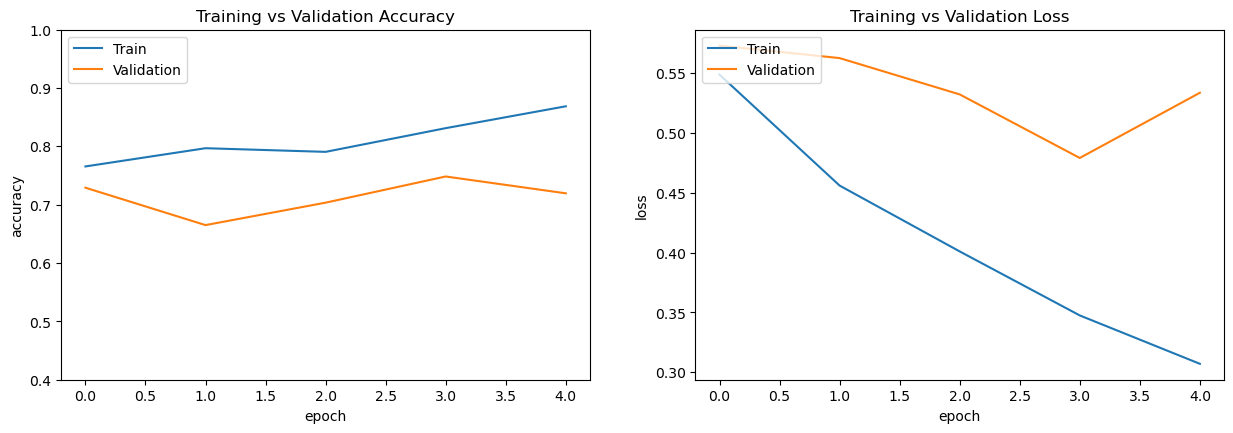

In [29]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

## 4. Predictions

In [39]:
#loaded_model = load_model(MODEL_DATAPATH)

# Load the ResNet50 model with the same architecture as the one used during training
base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)

# Load the weights from the file
base_model.load_weights(CHECKPOINT_PATH)

#model = VGG16(weights = MODEL_DATAPATH)
# Load the model weights
#weights = np.load(CHECKPOINT_PATH)
#loaded_model.set_weights(weights)

ValueError: A total of 58 objects could not be loaded. Example error message for object <Conv2D name=conv2_block1_1_conv, built=True>:

Layer 'conv2_block1_1_conv' expected 2 variables, but received 1 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Conv2D name=conv2_block1_1_conv, built=True>, <Conv2D name=conv2_block1_2_conv, built=True>, <BatchNormalization name=conv2_block1_3_bn, built=True>, <Conv2D name=conv2_block2_1_conv, built=True>, <Conv2D name=conv2_block2_2_conv, built=True>, <BatchNormalization name=conv2_block2_2_bn, built=True>, <BatchNormalization name=conv2_block2_3_bn, built=True>, <Conv2D name=conv2_block3_1_conv, built=True>, <Conv2D name=conv2_block3_2_conv, built=True>, <BatchNormalization name=conv2_block3_2_bn, built=True>, <BatchNormalization name=conv2_block3_3_bn, built=True>, <Conv2D name=conv3_block1_1_conv, built=True>, <Conv2D name=conv3_block1_2_conv, built=True>, <BatchNormalization name=conv3_block1_2_bn, built=True>, <BatchNormalization name=conv3_block1_0_bn, built=True>, <BatchNormalization name=conv3_block1_3_bn, built=True>, <Conv2D name=conv3_block2_1_conv, built=True>, <BatchNormalization name=conv3_block2_1_bn, built=True>, <Conv2D name=conv3_block2_2_conv, built=True>, <BatchNormalization name=conv3_block2_3_bn, built=True>, <Conv2D name=conv3_block3_1_conv, built=True>, <BatchNormalization name=conv3_block3_1_bn, built=True>, <Conv2D name=conv3_block3_2_conv, built=True>, <BatchNormalization name=conv3_block3_3_bn, built=True>, <Conv2D name=conv3_block4_1_conv, built=True>, <BatchNormalization name=conv3_block4_1_bn, built=True>, <Conv2D name=conv3_block4_2_conv, built=True>, <BatchNormalization name=conv3_block4_2_bn, built=True>, <BatchNormalization name=conv3_block4_3_bn, built=True>, <Conv2D name=conv4_block1_1_conv, built=True>, <BatchNormalization name=conv4_block1_1_bn, built=True>, <Conv2D name=conv4_block1_2_conv, built=True>, <BatchNormalization name=conv4_block1_0_bn, built=True>, <Conv2D name=conv4_block2_1_conv, built=True>, <Conv2D name=conv4_block2_2_conv, built=True>, <Conv2D name=conv4_block3_1_conv, built=True>, <Conv2D name=conv4_block3_2_conv, built=True>, <Conv2D name=conv4_block4_1_conv, built=True>, <Conv2D name=conv4_block4_2_conv, built=True>, <Conv2D name=conv4_block5_1_conv, built=True>, <Conv2D name=conv4_block5_2_conv, built=True>, <Conv2D name=conv4_block6_1_conv, built=True>, <BatchNormalization name=conv4_block6_1_bn, built=True>, <Conv2D name=conv4_block6_2_conv, built=True>, <BatchNormalization name=conv4_block6_2_bn, built=True>, <BatchNormalization name=conv4_block6_3_bn, built=True>, <Conv2D name=conv5_block1_1_conv, built=True>, <Conv2D name=conv5_block1_2_conv, built=True>, <BatchNormalization name=conv5_block1_3_bn, built=True>, <Conv2D name=conv5_block2_1_conv, built=True>, <Conv2D name=conv5_block2_2_conv, built=True>, <BatchNormalization name=conv5_block2_2_bn, built=True>, <BatchNormalization name=conv5_block2_3_bn, built=True>, <Conv2D name=conv5_block3_1_conv, built=True>, <BatchNormalization name=conv5_block3_1_bn, built=True>, <Conv2D name=conv5_block3_2_conv, built=True>, <BatchNormalization name=conv5_block3_2_bn, built=True>, <BatchNormalization name=conv5_block3_3_bn, built=True>]

In [40]:
# Make predictions for the test data.
pred = loaded_model.predict(test_generator)

c:\Users\Bea\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
pred

array([[0.82881856],
       [0.66847456],
       [0.7587309 ],
       [0.49887013],
       [0.8181151 ],
       [0.71339923],
       [0.22876811],
       [0.36334005],
       [0.91121423],
       [0.9485158 ],
       [0.9213381 ],
       [0.7456968 ],
       [0.886002  ],
       [0.9696433 ],
       [0.94709736],
       [0.67383814]], dtype=float32)

In [41]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [42]:
y_pred

[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [43]:
# Take the true information of the test data.
y_true = test_generator.classes

In [44]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [45]:
cm = confusion_matrix(y_true, y_pred)

Text(50.72222222222221, 0.5, 'Truth')

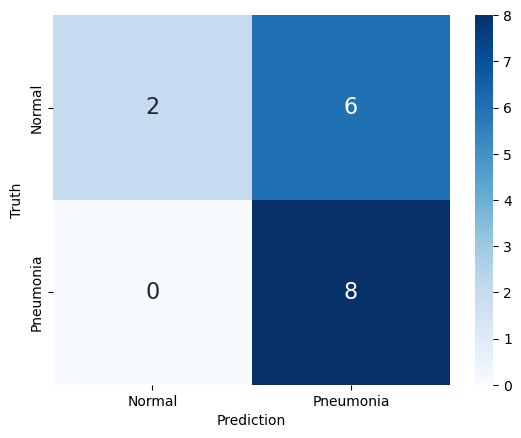

In [46]:
# Define the class names.
class_names = ['Normal', 'Pneumonia']

# Create the heatmap with class names as tick labels.
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Set the axis labels.
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

In [47]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.57      1.00      0.73         8

    accuracy                           0.62        16
   macro avg       0.79      0.62      0.56        16
weighted avg       0.79      0.62      0.56        16



In [48]:
# Classify the test data cases into true negative, true positive, false positive,
# and false negative cases.
confusion = []

for i, j in zip(y_true, y_pred):
  if i == 0 and j == 0:
    confusion.append('TN')
  elif i == 1 and j == 1:
    confusion.append('TP')
  elif i == 0 and j == 1:
    confusion.append('FP')
  else:
    confusion.append('FN')

In [49]:
confusion_table = pd.DataFrame(data = confusion, columns = ["Results"])
confusion_table

,Results
0,FP
1,FP
2,FP
3,FP
4,FP
5,FP
6,TN
7,TN
8,TP
9,TP


In [50]:
# Create a table with prediction, truth, and results.
confusion_table = pd.DataFrame({'Predicton':y_pred,
                                'Truth': y_true,
                                'Results': confusion})
confusion_table

,Predicton,Truth,Results
0,1,0,FP
1,1,0,FP
2,1,0,FP
3,1,0,FP
4,1,0,FP
5,1,0,FP
6,0,0,TN
7,0,0,TN
8,1,1,TP
9,1,1,TP


In [51]:
FPs = confusion_table[confusion_table['Results'] == 'FP']
FPs

,Predicton,Truth,Results
0,1,0,FP
1,1,0,FP
2,1,0,FP
3,1,0,FP
4,1,0,FP
5,1,0,FP


In [52]:
FNs = confusion_table[confusion_table['Results'] == 'FN']
FNs

,Predicton,Truth,Results


In [53]:
normal_test_images = glob.glob(VAL_DATASET + "/NORMAL/*.jpeg")
pneumonia_test_images = glob.glob(VAL_DATASET + "/PNEUMONIA/*.jpeg")

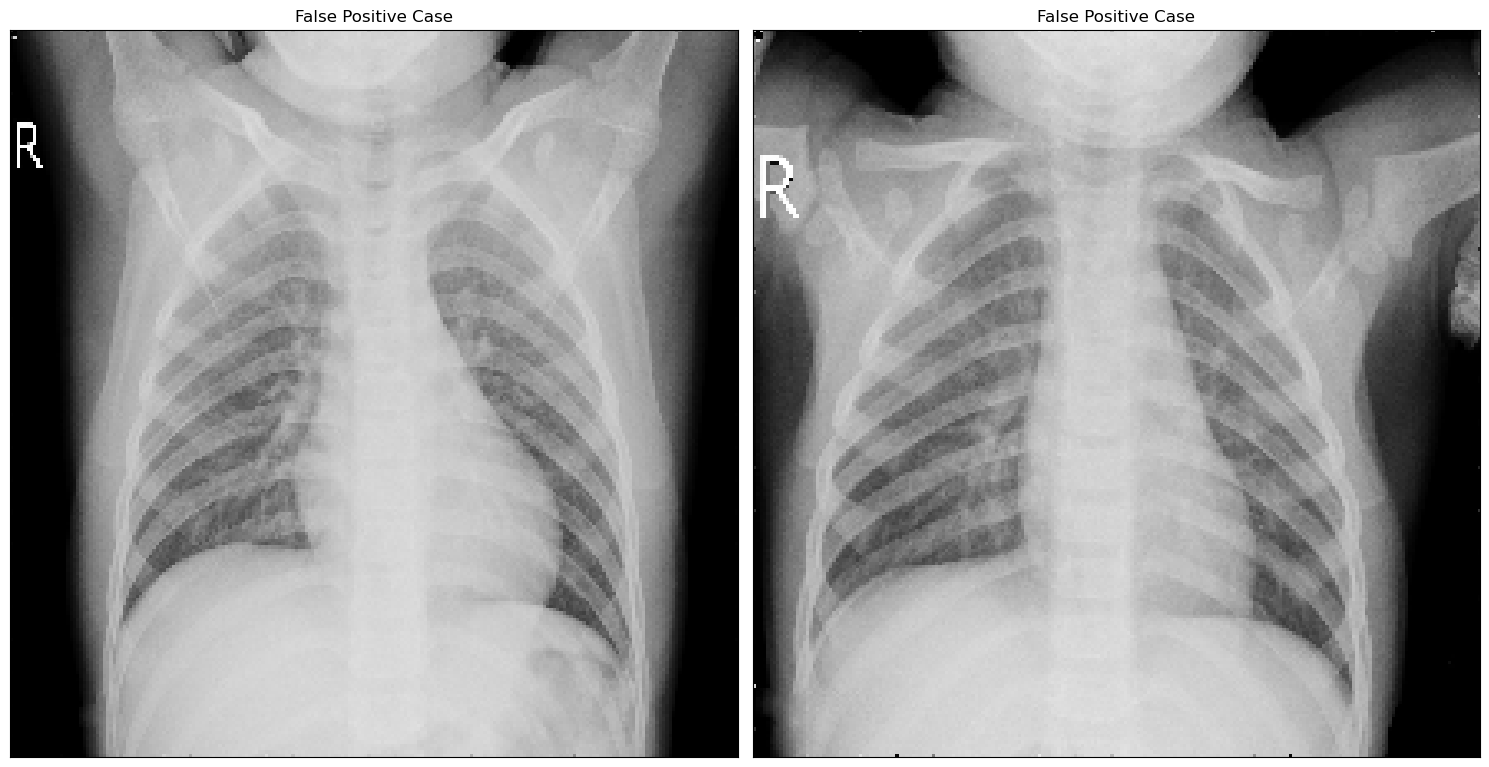

In [54]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
# Visualize the false positive case(s) in the test data.
for i, ax in zip(FPs.index, axes.flat):
    img = cv2.imread(normal_test_images[i])
    img = cv2.resize(img, (220, 220))
    ax.imshow(img)
    ax.set_title("False Positive Case")
fig.tight_layout()    

plt.show()

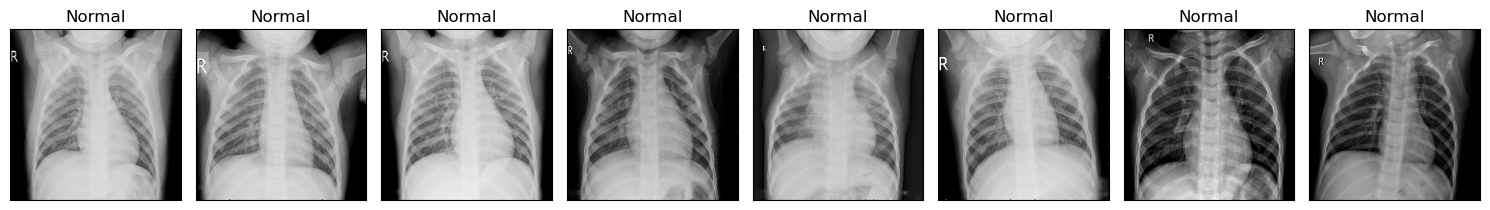

In [55]:
fig, axes = plt.subplots(nrows = 1, ncols = 8, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
# Visualize the test data for comparison.
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_test_images[i])
    img = cv2.resize(img, (220, 220))
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    

plt.show()